# Structured and time series data

This notebook contains an implementation of the 3rd place result in the Rossmann Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

## Preliminaries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
PATH='data/rossmann/'


from fastai.structured import *
from fastai.column_data import *


`np.set_printoptions(threshold=50, edgeitems=20)`

threshold : int, optional - Total number of array elements which trigger summarization rather than full repr (default 1000).

edgeitems : int, optional- Number of array items in summary at beginning and end of each dimension (default 3).edgeitems : int, optional

In [2]:
np.set_printoptions(threshold=50, edgeitems=20)

## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

In [3]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob.glob(f"{path}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")   #Notice this at end of file

NB: Files must finish by "\n", else some of the conversions fail...

### Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* state_names: List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [4]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

`pandas` allows to manipulate tables/data frames in python as one would in a DB.
using `pd.read_csv` to load the above (7) (fname).csv files as dataframes into the list `tables`.

`low_memory` : Internally process the file in chunks, resulting in lower memory use while parsing, but possibly mixed type inference.          

In [5]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False)  
          for fname in table_names]

### Missing index in Kaggle table 
test table (v2 from Kaggle) is missing Index which we need for skipping validation set. Add it now. (Or later?)

In [6]:
t = tables[6]
t['Id'] = t.index + 1

In [7]:
from IPython.display import HTML

### Quick look at the contents of each table:

Use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holliday, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [8]:
i = 0
for t in tables: 
    print("\nDF:", table_names[i]); i += 1 
    display(t.head(1))


DF: train


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1



DF: store


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN



DF: store_states


,Store,State
0,1,HE



DF: state_names


,StateName,State
0,BadenWuerttemberg,BW



DF: googletrend


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96



DF: weather


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215



DF: test


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

### summary of each DF using `display(DataFrameSummary(t).summary())`

In [9]:
# for t in tables: display(DataFrameSummary(t).summary())

# Data Cleaning / Feature Engineering

As a structured data problem, we have to go through all the cleaning and feature engineering, even though we're using an ANN.

In [10]:
train, store, store_states, state_names, googletrend, weather, test = tables
print("Training set=", len(train), "Test set =", len(test)) #, len(store), len(store_states), len(state_names), len(googletrend), len(weather)

Training set= 1017209 Test set = 41088


### Turn State Holidays to Boolean
We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [11]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

### Join Tables with `join_df`

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [12]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))   # if the 2 columns have the same then suffix is nothing ""

Join weather/state names.

In [13]:
weather = join_df(weather, state_names, "file", "StateName")
weather.head(1) 

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW


In pandas you can add new columns to a `dataframe` by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

In [14]:
googletrend.head(1)

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96


In [15]:
#Add Date and State columns to this DF
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.head(1)

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN


### Review Pandas indexing
We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list googletrend.State=='NI' and selecting "State".

In [16]:
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

### Using `add_datepart()` to extract particular date fields (from a complete datetime) for constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [17]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

#### The Googletrend data has a special category for the whole of the US (Germany?) - we'll pull that out so we can use it explicitly.

In [18]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

### Now outer join all of our data into a single dataframe. 

Recall that in outer joins, everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. 
One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

#### *Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, if you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [19]:
#Create a DF for the Stores
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [20]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [21]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [22]:
#Use MERGE for the trend_de ... WHY?
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [23]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

#### Drop the _y columns in both DFs

In [24]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

### Fill in missing values to avoid complications with `NA`'s. 

`NA` (Not Available) is how Pandas indicates missing values; Many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.  For example, for Year, the fill for NA is 1900, while for Month and Week we choose 1.

In [25]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

### Extract features `CompetitionOpenSince` and `CompetitionDaysOpen`. 
Note the use of `apply()` in mapping a function across dataframe values.  What we really want to know is how long has this store been open (in days) for this particular record.

In [26]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

### replace erroneous / outlying data 
eg negative days open when competition opened after the store,  etc.
This is based on the 3rd place winner process

In [27]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

### Limit the number of unique categories by adding fields

#### We add "CompetitionMonthsOpen" field
limiting the maximum to 2 years (24 months)to limit number of unique categories.

In [28]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
#joined.CompetitionMonthsOpen.unique()

#### Same process for Promo dates.

Notice below that the `.apply lambda` is very slow as it repeatedly invokes a Python function to a column. 
JH used this because he was unable to find a function that would (vectorized) compute (pandas or numpy) for year and week number into a date...
`lambda` is creating a function just for this single use...
Alternatively, we could have written create_promo2since and pass it by name:

def create_promo2since(x):
    return Week(x.Promo2SinceYear, x.Promo2SinceWeek).monday() 

In [29]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

### Save data -
joined is the training set, joined_test is the test set

In [30]:
import feather    # fast saving/loading of dataframes 

In [31]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')
print("Size of training set=", len(joined), "Size of test set=", len(joined_test))

Size of training set= 1017209 Size of test set= 41088


## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.  Hence, for a given store and a given event (eg StateHoliday) we will be able to know how long before the last one and how long until the next one. So we create 2 new columns for each such event.  We don't know of a library for this, so JH implemented `get_elapsed` below.

Upon initialization, this will result in datetime NA's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [32]:
def get_elapsed(sdf, fld, pre):   # GSG: Added sdf as sorted df parameter
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()  # arbitrary last date?
    last_store = 0
    res = []

    for s,v,d in zip(sdf.Store.values, sdf[fld].values, sdf.Date.values):
        if s != last_store:  # when it is a new store, we need to reset.
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d   # if it was a school holiday keep track of it
        ra = ((d-last_date).astype('timedelta64[D]') / day1).astype(int)
        if ra < 0: ra = 0  # GSG: Added check to avoid negative durations
        res.append(ra)       #.astype(int))
        #res.append(((d-last_date).astype('timedelta64[D]') / day1).astype(int))
    sdf[pre+fld] = res
    return sdf

Above notice the use of zip. Alternative way would have been to write:

for row in df.iterrows():

but this would iterate on a DF, which is **very slow**,  ie 300 times slower.
It is much faster to iterate over np.arrays.
zip means loop thru each of the list one at a time, and grab them.
above it is a loop over every store, every school holiday, and every date.
Very common pattern.

We'll be applying this (get_elapsed) to a subset of columns:

In [33]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

Below JH used the same variable, df, instead of 2 different variables....
That prevented the running of the notebook from begining to end, as it was 
requiring running all the following twice, once for train and once for test. 

In [34]:
df_train = train[columns]   #DF for the above train columns to df_train
df_test = test[columns]      #DF for the test set 

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [35]:
def add_before_after_count (df1, fld):
    df1 = df1.sort_values(['Store', 'Date'])  #Sort by Store, then Date
    df1 = get_elapsed(df1, fld, 'After')
    df1 = df1.sort_values(['Store', 'Date'], ascending=[True, False])
    df1 = get_elapsed(df1, fld, 'Before')
    return df1

Compute Before and After for SchoolHoliday, StateHoliday, and Promo, for both train and test set.

In [36]:
columnsBaA = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [37]:
for col in columnsBaA:
    df_train = add_before_after_count(df_train, col)
    df_test = add_before_after_count(df_test, col)
#df_train.head(1)

## Set the active index to Date.

In [38]:
df_train = df_train.set_index("Date")
df_test = df_test.set_index("Date")

#### Then set null values from elapsed field calculations to 0.

In [39]:
for dfx in [df_train, df_test]:
    for o in ['Before', 'After']:
        for p in columnsBaA:
            a = o+p
            dfx[a] = dfx[a].fillna(0)

### Demonstrate window functions in pandas to calculate rolling quantities.
Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [40]:
#df_train.head(1)
#df_test.head(1)

In [41]:
bwd = df_train[['Store']+columnsBaA].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd = df_train[['Store']+columnsBaA].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

In [42]:
for dfx in [bwd, fwd]:
    dfx.drop('Store',1,inplace=True)  #Drop the Store indiced grouped together
    dfx.reset_index(inplace=True)
#fwd.drop('Store',1,inplace=True)
#fwd.reset_index(inplace=True)

In [43]:
df_train.reset_index(inplace=True)
#df_train.head(1)

In [44]:
df_train = df_train.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_train = df_train.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
df_train.drop(columnsBaA,1,inplace=True)
#df_train.head(1)

In [45]:
bwd = df_test[['Store']+columnsBaA].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd = df_test[['Store']+columnsBaA].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

Drop the Store indices grouped together in the window function.

In [46]:
bwd.drop('Store',1,inplace=True)  #Drop the Store indiced grouped together
bwd.reset_index(inplace=True)
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [47]:
df_test = df_test.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_test = df_test.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
df_test.drop(columnsBaA,1,inplace=True)
df_test.head(1)

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,0,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0


In [48]:
#display(DataFrameSummary(df_train).summary())

### drop the Store indices grouped together in the window function.
Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [49]:
#bwd.drop('Store',1,inplace=True)
#bwd.reset_index(inplace=True)
#bwd.shape
#fwd.drop('Store',1,inplace=True)
#fwd.reset_index(inplace=True)

#for df in [df_train, df_test]:
#    df.reset_index(inplace=True)
#df_train.reset_index(inplace=True)

### Now we'll merge these values onto the df.

In [50]:
#df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
#df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

#df.drop(columnsBaA,1,inplace=True)
#df.head(1)

### Back-up large tables
It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [51]:
df_train.to_feather(f'{PATH}df_train')
df_train = pd.read_feather(f'{PATH}df_train')  #wrong argument? , index_col=0)
df_test.to_feather(f'{PATH}df_test')
df_test = pd.read_feather(f'{PATH}df_test')

In [52]:
for dfx in [df_train, df_test]:
    dfx["Date"] = pd.to_datetime(dfx.Date)

#print(df_train.columns, "\n\n", df_test.columns)

In [53]:
joined.shape, df_train.shape,  joined_test.shape, df_test.shape, df.shape

((1017209, 80), (1017209, 14), (41088, 79), (41088, 14), (41088, 79))

In [54]:
joined = join_df(joined, df_train, ['Store', 'Date'])
joined_test = join_df(joined_test, df_test, ['Store', 'Date'])

### Remove? Instances were the store was closed or had 0 sales.

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [55]:
#GSG: Testing with avoiding the 0 sales
#joined = joined[joined.Sales!=0]

We'll back this up as well.

In [56]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

# Create features

In [57]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

Below `T.` is Tranverse

In [58]:
#joined.head().T.head(20)

## Convert to input compatible for ANN
Now that we've engineered all our features, we need to convert to input compatible with an Artificial Neural Network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc.
If they are floating point, likely to be continous as it will be hard to have enugh categories.
If it is like age, we could decide if to treat them as categorical or continuos.

In [59]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [60]:
#joined_test.head().T.head(90)

In [61]:
#Convert the types of categorical and continuos
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    # for joined_test it will be done below by "apply_cats"
for v in contin_vars:
    joined[v] = joined[v].astype('float32') #Because pytorch expects all vars as float32
    joined_test[v] = joined_test[v].astype('float32')

In [62]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

Notice that the test set from Kaggle does not include an 'Id' field.

In [63]:
#joined.head(1)
#joined_test.head(1)

In [64]:
joined_test['Id'] = joined_test.index + 1    #V2 of test was missing the Id field

In [65]:
joined_test[dep] = 0   # We zero the sales for the test set
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

#joined_test.head(1) 

#### Use `apply_cats(df, trn)` 
to change any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    This is to guarantee that both DFs have the same set of categories.

In [66]:
apply_cats(joined_test, joined)

### We're going to run on a sample, `joined_samp`
The idea is to do all the work first on the sample, and once we are satisfied, then go below and use the full dataset.

In [67]:
n = len(joined)
idxs = get_cv_idxs(n, val_pct=150000/n)  #select random set
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

##### To run on the full dataset, use this instead:

In [68]:
samp_size = n
joined_samp = joined.set_index("Date")

#print("Sample size=", len(joined_samp), "Shape=", joined_samp.shape)
#joined_samp.head(1)

### We can now process our data...

- `proc_df` takes dataframe, pulls variable ('Sales') puts it in y, and returns df without it.
- Because `do_scale=True` it will substract the mean and divide by standard deviation....(ie it does scaling to 0-1). 
- We save `mapper` (has the mean and std deviation of the continuos column for each continuos variable). So we later apply the same for the test set so they have the same meaning.
- Also handles missing values, fills with median

In [69]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)

In [70]:
#GSG added: Avoid 0s returned by proc_df as we will take logs later
y[y==0] = 1

We take the log because the Kaggle competition defines that the evaluation metric is RMSPE. So we are penalized by the **ratio** between our answer and the correct answer.  By using the log we get an equivalent metric.  There is no RSMPE function in pytorch. 
Majority of regression competition use the log as the evaluation metric because we care more about ratios than about differences.

In [71]:
yl = np.log(y); yl

array([ 8.56846,  8.71012,  9.0257 ,  9.54646,  8.48094,  8.63959,  9.63848,  9.04688,  9.05544,  8.87975,
        9.25503,  9.10041,  9.08489,  8.7863 ,  9.12598,  9.23318,  9.03955,  9.21742,  9.01603,  9.16879,
       ...,  0.     ,  8.69299,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ])

In [72]:
df.head(1)  #take a look, now df is all numbers.

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,3,7,31,1,25,1,3,1,...,-0.147662,-2.812232,1.744363,1.743047,0.644376,0.0,1.273237,2.144211,-0.05103,-0.292796


In [73]:
joined_test.head(1)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Date,Id
0,1,4,2015,9,17,False,24,0,c,a,...,6.0,69.0,67.0,0.0,0.0,1.0,0.0,0,2015-09-17,1


In [74]:
joined_test = joined_test.set_index("Date")

In [75]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [76]:
df_test.head(1)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-17,1,4,3,9,17,1,25,1,3,1,...,0.361056,0.272087,0.333411,0.079555,-1.183596,0.0,1.273237,-0.466372,-0.05103,-0.292796


**NOTE: In time series data, cross-validation is not random.**
Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/).

One approach is to take the last 25% (or 10%) of rows (sorted by date) as our validation set.

In [77]:
train_ratio = 0.75
#train_ratio = 0.9
train_size = int(samp_size * train_ratio)
val_idx = list(range(train_size, len(df)))
#val_idx

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented below, where
`numpy.flatnonzero(a)` Return indices that are non-zero in the flattened version of a.

So now we create a validation set which is on the most recent period (1 Aug - 19Sept 2014)

In [78]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))
val_idx

array([334555, 334556, 334557, 334558, 334559, 334560, 334561, 334562, 334563, 334564, 334565, 334566, 334567,
       334568, 334569, 334570, 334571, 334572, 334573, 334574, ..., 379415, 379416, 379417, 379418, 379419,
       379420, 379421, 379422, 379423, 379424, 379425, 379426, 379427, 379428, 379429, 379430, 379431, 379432,
       379433, 379434])

In [79]:
#val_idx=[0]   #Reset val_idx to use the full training set
#val_idx

# Deep Learning
We're ready to put together our DL models.

#### Define the metric and related parameters
`Root-Mean-Squared Percent Error` (RMSPE) is the metric Kaggle used for this competition.

In [80]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

### Create ModelData object

Very similar to the image recognition process
- find training dataset
- find test set
- set a learner
- fit and go
But since we are not doing images, but structured data: `ColumnarModelData`

- PATH - where to store everything that you save later
- val_idx - which we will put in the validation set
- df - dataframe
- yl - target (dependent variable)
- cat_flds - which things we want to treat as categorical. At this time everything is a number

We can create a ModelData object directly from the data frame, passing it the test dataframe (df_test).
We must tell it which variables to treat as categorical (`cat_flds`)

In [81]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), 
                                       cat_flds=cat_vars, 
                                       bs=64, #bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [82]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]
#cat_sz

### Embeddings
We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.  (We define the dimensionality of the embeddings).   In NLP models it was found empiracally that you need about 600, because human languages are complex. But for some categories there is very little need for so many, eg for a StateHoliday.
JH rule of thumb is to look at how many discrite values the category has, and make the dimensionality of the embedding half of that, but not more than 50 (heuristic). `(c, min(50, (c+1)//2))`

In [83]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz] #Heuristic for size of embedding
#emb_szs

In [84]:
#??md.get_learner

### Get_learner and find Learning rate
0.04 is the dropout at the start, 
[1000, 500] are how many activation to start
[0.001,0.01] how much dropout in the later layers

In [85]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), 0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [86]:
m.lr_find()

A Jupyter Widget

 51%|█████     | 7708/15193 [01:40<01:37, 76.81it/s, loss=0.833]

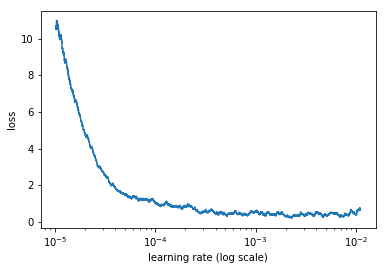

In [87]:
m.sched.plot(30) #100)

### Sample

In [88]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars), 0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [89]:
%time m.fit(lr, 4, metrics=[exp_rmspe])

A Jupyter Widget

  5%|▍         | 719/15193 [00:09<03:07, 77.40it/s, loss=0.531]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/german/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/german/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/german/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.138396   0.262989   165.02122 
    1      0.127265   0.268385   159.086876                       
    2      0.071071   0.251457   153.722943                       
    3      0.079969   0.286809   170.750593                       

CPU times: user 13min 43s, sys: 1min 2s, total: 14min 45s
Wall time: 13min 14s


[array([ 0.28681]), 170.7505932963295]

In [90]:
%time m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.129908   0.259613   152.273757
    1      0.057797   0.26258    158.51999                        
    2      0.068189   0.257991   149.226535                       
    3      0.051243   0.263498   163.426719                       
    4      0.063855   0.271352   166.181679                       

CPU times: user 17min 16s, sys: 1min 19s, total: 18min 35s
Wall time: 16min 42s


[array([ 0.27135]), 166.18167927421905]

In [91]:
%time m.fit(lr, 4, metrics=[exp_rmspe], cycle_len=4)

A Jupyter Widget

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.080181   0.263242   143.500412
    1      0.069481   0.26353    167.87209                        
    2      0.026753   0.255213   165.762702                       
    3      0.042425   0.259249   161.654453                       
    4      0.130556   0.267726   175.679363                       
    5      0.059325   0.240523   155.852028                       
    6      0.052931   0.247094   153.811485                       
    7      0.035474   0.244434   154.63188                        
    8      0.074629   0.244809   162.972233                       
    9      0.072618   0.277004   167.360017                       
    10     0.03513    0.251461   158.746426                       
    11     0.04639    0.254883   151.896704                       
    12     0.046894   0.259423   157.824838                       
    13     0.052072   0.283941   160.822069                       
    14     0.07188

[array([ 0.26905]), 156.93733382238131]

## All

In [92]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [93]:
m.fit(lr, 1, metrics=[exp_rmspe])

A Jupyter Widget

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.234306   0.270629   158.721049



[array([ 0.27063]), 158.72104863877888]

In [94]:
m.fit(lr, 3, metrics=[exp_rmspe])

A Jupyter Widget

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.069192   0.273726   149.120181
    1      0.114563   0.270484   151.180549                       
    2      0.105632   0.270051   145.917317                       



[array([ 0.27005]), 145.91731712973112]

In [95]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.075973   0.239576   130.563887
    1      0.067593   0.256751   130.264231                       
    2      0.052421   0.274901   140.921123                       



[array([ 0.2749]), 140.92112338340246]

### Test

In [96]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [97]:
%time m.fit(lr, 4, metrics=[exp_rmspe])

A Jupyter Widget

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.164063   0.265729   157.833708
    1      0.238327   0.272893   165.037305                       
    2      0.113807   0.26575    161.98482                        
    3      0.074931   0.252112   161.475302                       

CPU times: user 13min 38s, sys: 1min 4s, total: 14min 43s
Wall time: 13min 12s


[array([ 0.25211]), 161.47530176024821]

In [98]:
%time m.fit(lr, 4, metrics=[exp_rmspe], cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.081754   0.253845   155.381808
    1      0.066245   0.236513   143.967133                       
    2      0.121782   0.230671   141.855501                       
    3      0.043868   0.235618   143.619884                       

CPU times: user 13min 49s, sys: 1min 2s, total: 14min 52s
Wall time: 13min 21s


[array([ 0.23562]), 143.61988433357672]

In [99]:
m.save('val0')
m.load('val0')

In [100]:
x,y=m.predict_with_targs()

In [101]:
exp_rmspe(x,y)

289.05920944073034

In [102]:
pred_test=m.predict(True)  #True to state this is the test set.  predict returns the logs of the predictions

pred_test = np.exp(pred_test)  #now get the actuals
#pred_test

In [103]:
joined_test['Sales']=pred_test

In [104]:
#joined_test['Sales']

In [105]:
csv_fn=f'{PATH}tmp/sub.csv'

joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

FileLink(csv_fn)

/home/german/fastai/courses/dl1/data/rossmann/tmp/sub.csv

# RandomForest

In [106]:
from sklearn.ensemble import RandomForestRegressor

In [107]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [108]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [109]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.9973536825684356,
 0.97633665016753624,
 0.99134121749090809,
 306.4106112946695)

In [110]:
np.exp(preds)
trn
#forest_test = np.
#forest_test['Sales']=np.exp(preds)
#forest_test

array([[    1.     ,     5.     ,     3.     ,     7.     ,    31.     ,     1.     ,    25.     ,
            1.     ,     3.     ,     1.     ,     0.     ,    16.     ,     1.     ,     5.     ,
           31.     ,     1.     ,     2.     ,     6.     ,     1.     ,     1.     ,     2.     ,
            6.     ,    -0.53874,     1.02445,     0.81863,     0.32505,     0.61112,    -1.51079,
           -1.62656,     0.14844,    -0.14766,    -2.81223,     1.74436,     1.74305,     0.64438,
            0.     ,     1.27324,     2.14421,    -0.05103,    -0.2928 ],
       [    2.     ,     5.     ,     3.     ,     7.     ,    31.     ,     1.     ,    25.     ,
           26.     ,     1.     ,     1.     ,     2.     ,    15.     ,     3.     ,    12.     ,
           31.     ,     1.     ,     2.     ,     6.     ,     1.     ,     1.     ,     2.     ,
            6.     ,    -0.62957,     0.5519 ,     0.40421,     0.17024,     0.87028,    -0.90502,
           -1.2699 ,    -0.97008,  

In [111]:
#train.StateHoliday = train.StateHoliday != "0"